In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, Normalizer
from pyspark.sql import functions as F
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.clustering import KMeans
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Starting a Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Mobile-Price-Classification').getOrCreate()

In [4]:
df = spark.read.format("csv")\
    .option("inferSchema", "true")\
    .option("header", "true")\
    .option("sep", ",")\
    .load('Mobile_Price_Classification.csv')

In [5]:
df.createOrReplaceTempView("mobile_price")
#The createOrReplaceTempView function registers a DataFrame as a SQL temporary view.
#This allows you to run SQL queries against the DataFrame using Spark SQL
df.printSchema()

root
 |-- battery_power: integer (nullable = true)
 |-- blue: integer (nullable = true)
 |-- clock_speed: double (nullable = true)
 |-- dual_sim: integer (nullable = true)
 |-- fc: integer (nullable = true)
 |-- four_g: integer (nullable = true)
 |-- int_memory: integer (nullable = true)
 |-- m_dep: double (nullable = true)
 |-- mobile_wt: integer (nullable = true)
 |-- n_cores: integer (nullable = true)
 |-- pc: integer (nullable = true)
 |-- px_height: integer (nullable = true)
 |-- px_width: integer (nullable = true)
 |-- ram: integer (nullable = true)
 |-- sc_h: integer (nullable = true)
 |-- sc_w: integer (nullable = true)
 |-- talk_time: integer (nullable = true)
 |-- three_g: integer (nullable = true)
 |-- touch_screen: integer (nullable = true)
 |-- wifi: integer (nullable = true)
 |-- price_range: integer (nullable = true)



In [6]:
df.show(2)

+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+-----------+
|battery_power|blue|clock_speed|dual_sim| fc|four_g|int_memory|m_dep|mobile_wt|n_cores| pc|px_height|px_width| ram|sc_h|sc_w|talk_time|three_g|touch_screen|wifi|price_range|
+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+---------+-------+------------+----+-----------+
|          842|   0|        2.2|       0|  1|     0|         7|  0.6|      188|      2|  2|       20|     756|2549|   9|   7|       19|      0|           0|   1|          1|
|         1021|   1|        0.5|       1|  0|     1|        53|  0.7|      136|      3|  6|      905|    1988|2631|  17|   3|        7|      1|           1|   0|          2|
+-------------+----+-----------+--------+---+------+----------+-----+---------+-------+---+---------+--------+----+----+----+-----

In [7]:
#proportion of each price range in dataset
df.groupBy("price_range").count().show()

+-----------+-----+
|price_range|count|
+-----------+-----+
|          1|  500|
|          3|  500|
|          2|  500|
|          0|  500|
+-----------+-----+



In [8]:
#avarge Battery for each price range 
df.groupBy("price_range").avg("battery_power").orderBy('price_range').show()


+-----------+------------------+
|price_range|avg(battery_power)|
+-----------+------------------+
|          0|          1116.902|
|          1|          1228.868|
|          2|           1228.32|
|          3|          1379.984|
+-----------+------------------+



In [9]:
#averge raw for each price range
df.groupBy("price_range").avg("ram").orderBy('price_range').show()

+-----------+--------+
|price_range|avg(ram)|
+-----------+--------+
|          0| 785.314|
|          1| 1679.49|
|          2|2582.816|
|          3|3449.232|
+-----------+--------+



In [10]:
df.groupBy("n_cores").sum("clock_speed").orderBy('n_cores').show()

+-------+------------------+
|n_cores|  sum(clock_speed)|
+-------+------------------+
|      1|384.00000000000017|
|      2|             359.0|
|      3|384.00000000000017|
|      4|             423.4|
|      5|350.00000000000006|
|      6| 352.4000000000001|
|      7| 404.2999999999999|
|      8| 387.3999999999997|
+-------+------------------+



In [11]:
#average megapixel for primary camara by price range
df.groupBy("price_range").avg("pc").orderBy('price_range').show()

+-----------+-------+
|price_range|avg(pc)|
+-----------+-------+
|          0|  9.574|
|          1|  9.924|
|          2| 10.018|
|          3|  10.15|
+-----------+-------+



In [12]:
#average internal memory for each price range
df.groupBy("price_range").avg("int_memory").orderBy('price_range').show()

+-----------+---------------+
|price_range|avg(int_memory)|
+-----------+---------------+
|          0|         31.174|
|          1|         32.116|
|          2|          30.92|
|          3|         33.976|
+-----------+---------------+



# correlation matrix between independent variable

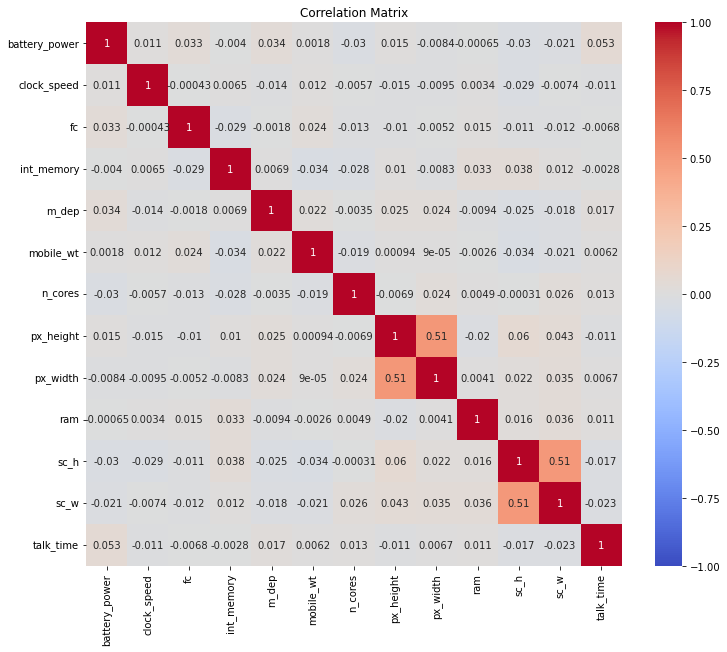

In [13]:
import seaborn as sns
vector_col = "corr_features"
columns = ['battery_power','clock_speed','fc','int_memory','m_dep','mobile_wt','n_cores','px_height','px_width','ram','sc_h'
           ,'sc_w','talk_time']
assembler = VectorAssembler(inputCols= columns, outputCol = vector_col)
graph_vector = assembler.transform(df).select(vector_col)
matrix = Correlation.corr(graph_vector,vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
cf = spark.createDataFrame(corrmatrix, columns)
corr_df = cf.toPandas()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', xticklabels=columns, yticklabels=columns, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# feature engineering

In [14]:
# missing value
for col in df.columns:
    print(col.ljust(15), df.filter(df[col].isNull()).count())

battery_power   0
blue            0
clock_speed     0
dual_sim        0
fc              0
four_g          0
int_memory      0
m_dep           0
mobile_wt       0
n_cores         0
pc              0
px_height       0
px_width        0
ram             0
sc_h            0
sc_w            0
talk_time       0
three_g         0
touch_screen    0
wifi            0
price_range     0


since there is high correlation between (px_height, px_width) and (sc_h, sc_w), we don't be using those columns driectiy we will calculating pixel screan resolution and  screan resolution by
pixel screan resolution =  px_height * px_width
screan resolution = sc_h * sc_w

In [15]:
df = df.withColumn('sc_area',F.col('sc_h')*F.col('sc_w')).withColumn('px_area',F.col('px_height')*F.col('px_width'))

In [16]:
# COMBINING four_g AND three_g INTO ONE COLUMN
df = df.withColumn('network',F.when(F.col('four_g')==1 , '4G').when(F.col('three_g')==1 , '3G').otherwise('2G'))


In [17]:
#DROPPING COLUMNS
df = df.drop('four_g', 'three_g', 'sc_w', 'sc_h', 'px_height', 'px_width')

In [18]:
df.show()

+-------------+----+-----------+--------+---+----------+-----+---------+-------+---+----+---------+------------+----+-----------+-------+-------+-------+
|battery_power|blue|clock_speed|dual_sim| fc|int_memory|m_dep|mobile_wt|n_cores| pc| ram|talk_time|touch_screen|wifi|price_range|sc_area|px_area|network|
+-------------+----+-----------+--------+---+----------+-----+---------+-------+---+----+---------+------------+----+-----------+-------+-------+-------+
|          842|   0|        2.2|       0|  1|         7|  0.6|      188|      2|  2|2549|       19|           0|   1|          1|     63|  15120|     2G|
|         1021|   1|        0.5|       1|  0|        53|  0.7|      136|      3|  6|2631|        7|           1|   0|          2|     51|1799140|     4G|
|          563|   1|        0.5|       1|  2|        41|  0.9|      145|      5|  6|2603|        9|           1|   0|          2|     22|2167308|     4G|
|          615|   1|        2.5|       0|  0|        10|  0.8|      131|    

In [19]:
# Splitting data into training and validation sets
train_df, valid_df = df.randomSplit([0.7,0.3])

In [20]:
# Converting Sex and Embarked columns to numeric index
network_indexer = StringIndexer(inputCols=['network'],outputCols=['network_index'])
indexer_model = network_indexer.fit(train_df)
train_1 = indexer_model.transform(train_df) # Transforming and dropping original columns
train_1.show(5)

+-------------+----+-----------+--------+---+----------+-----+---------+-------+---+----+---------+------------+----+-----------+-------+-------+-------+-------------+
|battery_power|blue|clock_speed|dual_sim| fc|int_memory|m_dep|mobile_wt|n_cores| pc| ram|talk_time|touch_screen|wifi|price_range|sc_area|px_area|network|network_index|
+-------------+----+-----------+--------+---+----------+-----+---------+-------+---+----+---------+------------+----+-----------+-------+-------+-------+-------------+
|          501|   1|        0.5|       1| 14|        22|  0.5|      174|      6| 20|3077|       17|           0|   0|          2|     51| 391004|     2G|          2.0|
|          502|   0|        0.8|       0|  7|        52|  1.0|       82|      6|  8|2666|       20|           1|   0|          2|     20| 325679|     3G|          1.0|
|          502|   0|        1.5|       1|  7|        37|  0.2|      199|      2| 12|1649|       14|           1|   0|          1|      6|1276050|     2G|       

# Decision Tree Classifier

In [21]:
# convert stringIndexer to numerical data
#network_indexer = StringIndexer(inputCols=['network'],outputCols='network_index', handleInvalid='keep')

# vecter assembler is used to create a vector of input features
assembler = VectorAssembler(inputCols=['battery_power','blue','clock_speed','dual_sim','fc','int_memory','m_dep','mobile_wt',
                                       'n_cores','pc','px_area','ram','sc_area','touch_screen','wifi','network_index'],
                            outputCol='features')

# create an object of Decision Tree Classifier
model = DecisionTreeClassifier(labelCol='price_range', maxBins=5000)

# pipeline is used to pass the data through indexer and assembler simultaneously also help to pre-process the test data
pipe = Pipeline(stages=[network_indexer, assembler, model])
fit_model = pipe.fit(train_df)
results = fit_model.transform(valid_df)

In [22]:
results.select(['price_range','prediction']).show()

+-----------+----------+
|price_range|prediction|
+-----------+----------+
|          1|       1.0|
|          1|       1.0|
|          0|       0.0|
|          2|       2.0|
|          0|       0.0|
|          2|       2.0|
|          0|       0.0|
|          0|       0.0|
|          3|       3.0|
|          1|       1.0|
|          1|       2.0|
|          0|       1.0|
|          2|       2.0|
|          0|       0.0|
|          1|       1.0|
|          1|       1.0|
|          3|       3.0|
|          0|       1.0|
|          0|       0.0|
|          1|       1.0|
+-----------+----------+
only showing top 20 rows



In [23]:
results.groupBy('prediction').count().sort('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  149|
|       1.0|  149|
|       2.0|  150|
|       3.0|  128|
+----------+-----+



In [24]:
results.groupBy('price_range').count().sort('price_range').show()

+-----------+-----+
|price_range|count|
+-----------+-----+
|          0|  160|
|          1|  146|
|          2|  139|
|          3|  131|
+-----------+-----+



In [25]:


from pyspark.sql.functions import col  # Import for selecting columns

# Collect labels and predictions as lists
true_labels = results.select(col('price_range')).rdd.map(lambda row: row[0]).collect()
predicted_labels = results.select(col('prediction')).rdd.map(lambda row: row[0]).collect()

# Import and use confusion matrix from scikit-learn
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(true_labels, predicted_labels)
print(confusion_matrix)


[[142  18   0   0]
 [  7 121  18   0]
 [  0  10 116  13]
 [  0   0  16 115]]


In [26]:
acc_enaluator = MulticlassClassificationEvaluator(labelCol="price_range", predictionCol='prediction', metricName='accuracy')
d_accuracy = acc_enaluator.evaluate(results)
d_accuracy

0.8576388888888888

In [27]:
f1_enaluator = MulticlassClassificationEvaluator(labelCol="price_range", predictionCol='prediction', metricName='f1')
d_f1 = f1_enaluator.evaluate(results)
d_f1

0.8589259186201477

In [28]:
precision_enaluator = MulticlassClassificationEvaluator(labelCol="price_range", predictionCol='prediction', metricName='precisionByLabel')
d_precision = precision_enaluator.evaluate(results)
d_precision

0.9530201342281879

In [29]:
recall_enaluator = MulticlassClassificationEvaluator(labelCol="price_range", predictionCol='prediction', metricName='recallByLabel')
recall_precision = recall_enaluator.evaluate(results)
recall_precision

0.8875

In [30]:
def sanitycheckRam(df, columnName):
    return df.withColumn('sanity', F.when(F.col(columnName)<1000,0).when(F.col(columnName)<2000,1).when(F.col(columnName)<3000,2).otherwise(3))

In [31]:
sanitycheckRam(results.groupBy('prediction').agg(F.avg('ram').alias('ramAvg')),'ramAvg').sort('prediction').show()

+----------+------------------+------+
|prediction|            ramAvg|sanity|
+----------+------------------+------+
|       0.0|  783.738255033557|     0|
|       1.0|1605.2281879194632|     1|
|       2.0|2575.9533333333334|     2|
|       3.0|      3492.7421875|     3|
+----------+------------------+------+



According to the sanity check function defined in the program, if ram is below 1000, it should be in class O, if it is between 1000 and 2000 it should be in class 1, between 2000 and 3000, it should be in class 2 otherwise class 3. If we pass the avgram value of our predictions to the sanity check function, we can see that we are getting accurate results, as the sanity value matches our prediction which proves the validity of our model.

# building random forest model

In [32]:
rl = RandomForestClassifier(featuresCol = 'features', labelCol='price_range')
pipe = Pipeline(stages=[network_indexer, assembler, rl])
fit_model = pipe.fit(train_df)
results2 = fit_model.transform(valid_df)

In [33]:
results2.select(['price_range','prediction']).show()

+-----------+----------+
|price_range|prediction|
+-----------+----------+
|          1|       2.0|
|          1|       2.0|
|          0|       0.0|
|          2|       3.0|
|          0|       1.0|
|          2|       2.0|
|          0|       0.0|
|          0|       0.0|
|          3|       3.0|
|          1|       2.0|
|          1|       2.0|
|          0|       1.0|
|          2|       2.0|
|          0|       0.0|
|          1|       1.0|
|          1|       1.0|
|          3|       2.0|
|          0|       0.0|
|          0|       0.0|
|          1|       2.0|
+-----------+----------+
only showing top 20 rows



In [34]:
results2.groupBy('prediction').count().sort('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  159|
|       1.0|  153|
|       2.0|  132|
|       3.0|  132|
+----------+-----+



In [35]:
from pyspark.sql.functions import col  # Import for selecting columns

# Collect labels and predictions as lists
true_labels = results2.select(col('price_range')).rdd.map(lambda row: row[0]).collect()
predicted_labels = results2.select(col('prediction')).rdd.map(lambda row: row[0]).collect()

# Import and use confusion matrix from scikit-learn
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(true_labels, predicted_labels)
print(confusion_matrix)


[[141  19   0   0]
 [ 18 110  18   0]
 [  0  24  97  18]
 [  0   0  17 114]]


In [36]:
rl_accuracy = acc_enaluator.evaluate(results2)
rl_accuracy

0.8020833333333334

In [37]:
rl_f1 = f1_enaluator.evaluate(results2)
rl_f1

0.8019771361332934

In [38]:
rl_precision = precision_enaluator.evaluate(results2)
rl_precision

0.8867924528301887

In [39]:
rl_recall = recall_enaluator.evaluate(results2)
rl_recall

0.88125

In [40]:
sanitycheckRam(results2.groupBy('prediction').agg(F.avg('ram').alias('ramAvg')),'ramAvg').sort('prediction').show()

+----------+------------------+------+
|prediction|            ramAvg|sanity|
+----------+------------------+------+
|       0.0| 768.5849056603773|     0|
|       1.0|1683.6339869281046|     1|
|       2.0|2678.4772727272725|     2|
|       3.0|            3455.0|     3|
+----------+------------------+------+



According to the sanity check function defined in the program, if ram is below 1000, it should be in class O, if it is between 1000 and 2000 it should be in class 1, between 2000 and 3000, it should be in class 2 otherwise class 3. If we pass the avgram value of our predictions to the sanity check function, we can see that we are getting accurate results, as the sanity value matches our prediction which proves the validity of our model.

# Naive Bayes

In [41]:
# Define the stages of the pipeline
nb = NaiveBayes(featuresCol='features', labelCol='price_range')
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
normalizer = Normalizer(inputCol='scaled_features', outputCol='norm_features', p=1.0)

# Assuming network_indexer and assembler are defined elsewhere in your code
pipe = Pipeline(stages=[network_indexer, assembler, scaler, normalizer, nb])

# Fit the pipeline to the training data
fit_model = pipe.fit(train_df)

# Transform the validation data
results3 = fit_model.transform(valid_df)

In [42]:
results3.select(['price_range','prediction']).show()

+-----------+----------+
|price_range|prediction|
+-----------+----------+
|          1|       3.0|
|          1|       3.0|
|          0|       0.0|
|          2|       3.0|
|          0|       3.0|
|          2|       3.0|
|          0|       2.0|
|          0|       2.0|
|          3|       1.0|
|          1|       3.0|
|          1|       3.0|
|          0|       3.0|
|          2|       3.0|
|          0|       0.0|
|          1|       1.0|
|          1|       3.0|
|          3|       1.0|
|          0|       1.0|
|          0|       0.0|
|          1|       3.0|
+-----------+----------+
only showing top 20 rows



In [43]:
results3.groupBy('prediction').count().sort('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  136|
|       1.0|  108|
|       2.0|  115|
|       3.0|  217|
+----------+-----+



In [44]:
from pyspark.sql.functions import col  # Import for selecting columns

# Collect labels and predictions as lists
true_labels = results3.select(col('price_range')).rdd.map(lambda row: row[0]).collect()
predicted_labels = results3.select(col('prediction')).rdd.map(lambda row: row[0]).collect()

# Import and use confusion matrix from scikit-learn
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(true_labels, predicted_labels)
print(confusion_matrix)


[[92  7 46 15]
 [35 34 36 41]
 [ 7 24 20 88]
 [ 2 43 13 73]]


In [45]:
nb_accuracy = acc_enaluator.evaluate(results3)
nb_accuracy

0.3802083333333333

In [46]:
nb_f1 = f1_enaluator.evaluate(results3)
nb_f1

0.37395070751242687

In [47]:
nb_precision = precision_enaluator.evaluate(results3)
nb_precision

0.6764705882352942

In [48]:
nb_recall = recall_enaluator.evaluate(results3)
nb_recall

0.575

In [49]:
sanitycheckRam(results2.groupBy('prediction').agg(F.avg('ram').alias('ramAvg')),'ramAvg').sort('prediction').show()

+----------+------------------+------+
|prediction|            ramAvg|sanity|
+----------+------------------+------+
|       0.0| 768.5849056603773|     0|
|       1.0|1683.6339869281046|     1|
|       2.0|2678.4772727272725|     2|
|       3.0|            3455.0|     3|
+----------+------------------+------+



# Business Conclusion
Based on our analysis, mobile features used in model creation are very important deciding factors while estimating the price range for the device. Based on our statistical analysis, features like battery power, clock speed, internal memory, number of cores, ram are the most important features for prediction. For any company entering the market can use this machine learning model to estimate the price range for their device based on these features. This is a very significant problem which is solved using machine learning and can be used by the industry to predict price range for any device.